In [38]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras 
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import InputLayer, BatchNormalization,Activation, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
import tqdm
import keras
import glob
import cv2
import warnings
from keras.preprocessing import image
import numpy as np
warnings.filterwarnings("ignore")
import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)

Num GPUs Available:  0


In [35]:
batch_size=60
img_size=(224,224)
image_generator = ImageDataGenerator(rescale=1/255., validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     
train_data = image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimers-ADNI\\train',shuffle=True,target_size=img_size, subset="training",class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.7) 
validation_data= image_generator.flow_from_directory(batch_size=batch_size,directory='F:\Alzheimers-ADNI\\test',shuffle=True,target_size=img_size,class_mode='categorical')

submission = image_generator.flow_from_directory(directory='F:\Alzheimers-ADNI\\test',shuffle=False,subset="validation",target_size=img_size, class_mode=None)

Found 1101 images belonging to 5 classes.
Found 195 images belonging to 5 classes.
Found 134 images belonging to 5 classes.


In [36]:
train_data.class_indices

{'Final AD JPEG': 0,
 'Final CN JPEG': 1,
 'Final EMCI JPEG': 2,
 'Final LMCI JPEG': 3,
 'Final MCI JPEG': 4}

In [37]:
batch_size=60
epoch=10
callback= keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)

In [42]:
rn50 = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in rn50.layers:
    layer.trainable = False
x = Flatten()(rn50.output)
x = Dense(128, activation='relu')(x)
out = Dense(5, activation='softmax')(x)

modelrn50= Model(inputs=rn50.input, outputs=out)

# Compiling
modelrn50.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

#Summary
modelrn50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [43]:
hist_rn50=modelrn50.fit(train_data, epochs=epoch, validation_data=validation_data, callbacks=callback)

Epoch 1/10
19/19 [==============================] - 83s 4s/step - loss: 7.0646 - accuracy: 0.2352 - val_loss: 2.8901 - val_accuracy: 0.4615
Epoch 2/10
19/19 [==============================] - 79s 4s/step - loss: 1.9503 - accuracy: 0.3924 - val_loss: 1.4328 - val_accuracy: 0.4615
Epoch 3/10
19/19 [==============================] - 79s 4s/step - loss: 1.5012 - accuracy: 0.3969 - val_loss: 1.4138 - val_accuracy: 0.4667
Epoch 4/10
19/19 [==============================] - 79s 4s/step - loss: 1.4010 - accuracy: 0.4678 - val_loss: 1.4744 - val_accuracy: 0.4667
Epoch 5/10
19/19 [==============================] - 81s 4s/step - loss: 1.3780 - accuracy: 0.4687 - val_loss: 1.3815 - val_accuracy: 0.4564
Epoch 6/10
19/19 [==============================] - 81s 4s/step - loss: 1.3853 - accuracy: 0.4469 - val_loss: 1.3707 - val_accuracy: 0.4667
Epoch 7/10
19/19 [==============================] - 80s 4s/step - loss: 1.3531 - accuracy: 0.4723 - val_loss: 1.4218 - val_accuracy: 0.4667
Epoch 8/10
19/19 [==

In [46]:
loss_rn50,accuracy_rn50= modelrn50.evaluate(validation_data)

4/4 [==============================] - 12s 3s/step - loss: 1.4196 - accuracy: 0.4667


In [47]:
Y_pred = modelrn50.predict_generator(validation_data, 1000 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data.classes, y_pred))
print('Classification Report')
target_names = ['Final AD JPEG','Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG','Final MCI JPEG']
print(classification_report(validation_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 0 26  0  0  0]
 [ 0 87  0  0  0]
 [ 3 33  0  0  0]
 [ 0 11  0  0  0]
 [ 1 34  0  0  0]]
Classification Report
                 precision    recall  f1-score   support

  Final AD JPEG       0.00      0.00      0.00        26
  Final CN JPEG       0.46      1.00      0.63        87
Final EMCI JPEG       0.00      0.00      0.00        36
Final LMCI JPEG       0.00      0.00      0.00        11
 Final MCI JPEG       0.00      0.00      0.00        35

       accuracy                           0.45       195
      macro avg       0.09      0.20      0.13       195
   weighted avg       0.20      0.45      0.28       195



by diffrent method

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.13.0


In [3]:
WORK_DIR = './Alzheimers-ADNI'

CLASSES = [ 'Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 1296 images belonging to 5 classes.


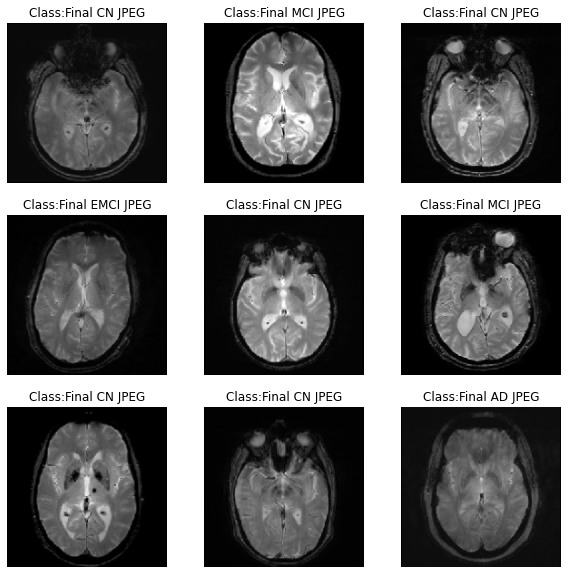

In [9]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1296)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [10]:
train_data, train_labels = train_data_gen.next()

In [11]:
print(train_data.shape, train_labels.shape)

(1296, 176, 176, 3) (1296, 5)


In [12]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2900, 176, 176, 3) (2900, 5)


In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [14]:
resnet_model = ResNet50(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [15]:
for layer in resnet_model.layers:
    layer.trainable=False

In [16]:
custom_resnet_model = Sequential([
        resnet_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(5, activation='softmax')        
    ], name = "resnet_cnn_model")

In [17]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# CALLBACKS = rop_callback
    
custom_resnet_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_resnet_model.summary()

Model: "resnet_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)          

In [19]:
EPOCHS = 15

history = custom_resnet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,steps_per_epoch=256)

Epoch 1/15
256/256 [==============================] - 129s 472ms/step - loss: 2.1196 - accuracy: 0.7480 - precision: 0.1984 - recall: 0.0854 - auc: 0.4937 - f1_score: 0.1125 - val_loss: 1.6390 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5194 - val_f1_score: 0.0000e+00
Epoch 2/15
256/256 [==============================] - 113s 441ms/step - loss: 1.8879 - accuracy: 0.7697 - precision: 0.1912 - recall: 0.0469 - auc: 0.5089 - f1_score: 0.0699 - val_loss: 1.6186 - val_accuracy: 0.7996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5433 - val_f1_score: 0.0000e+00
Epoch 3/15
256/256 [==============================] - 114s 447ms/step - loss: 1.7772 - accuracy: 0.7857 - precision: 0.2008 - recall: 0.0239 - auc: 0.5087 - f1_score: 0.0397 - val_loss: 1.6120 - val_accuracy: 0.7978 - val_precision: 0.1429 - val_recall: 0.0022 - val_auc: 0.5605 - val_f1_score: 0.0039
Epoch 4/15
256/256 [==============================] - 118s 460ms/step 

In [20]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_resnet_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

19/19 [==============================] - 19s 1s/step - loss: 1.5544 - accuracy: 0.8000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6114 - f1_score: 0.0000e+00
Testing Accuracy: 80.00%


In [21]:
pred_labels = custom_resnet_model.predict(test_data)

19/19 [==============================] - 25s 1s/step


In [22]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                 precision    recall  f1-score   support

  Final AD JPEG       0.00      0.00      0.00       112
  Final CN JPEG       0.32      0.63      0.43       125
Final EMCI JPEG       0.27      0.23      0.25       117
Final LMCI JPEG       0.29      0.54      0.38       116
 Final MCI JPEG       0.33      0.05      0.08       110

      micro avg       0.30      0.30      0.30       580
      macro avg       0.24      0.29      0.23       580
   weighted avg       0.24      0.30      0.23       580
    samples avg       0.30      0.30      0.30       580



c:\logs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "resnet50adni.pkl"  
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(custom_resnet_model, file)